Loading and preparing data...

Creating Linear model (order=1)...
Sampling from Linear model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


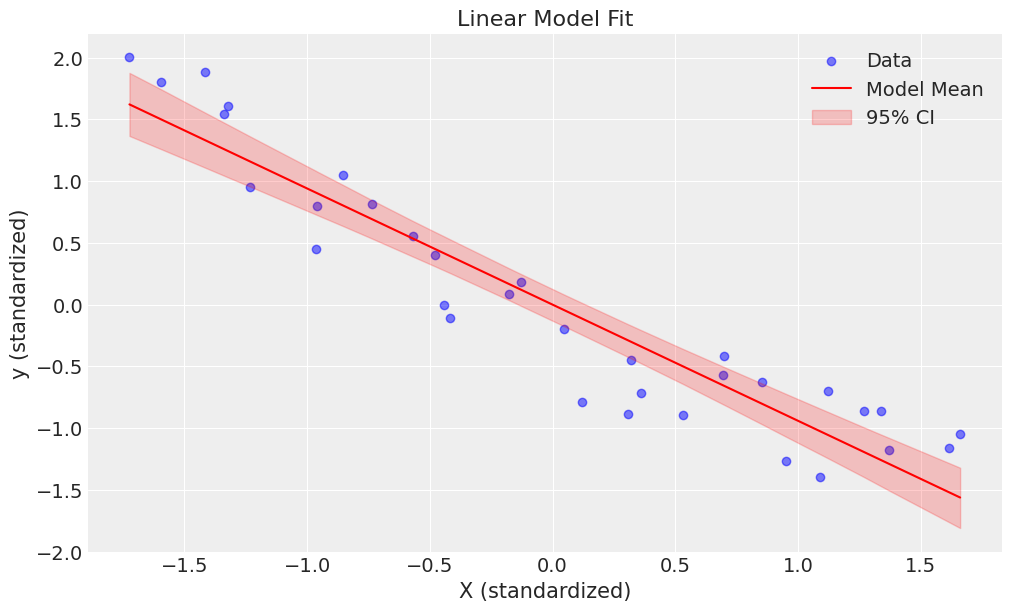


Creating Quadratic model (order=2)...
Sampling from Quadratic model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


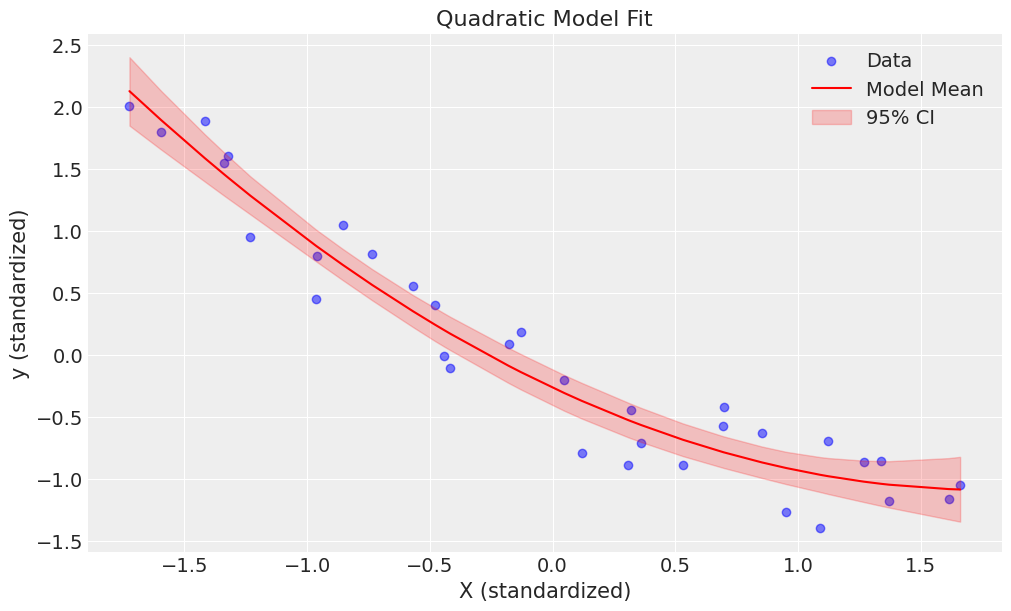


Creating Cubic model (order=3)...
Sampling from Cubic model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


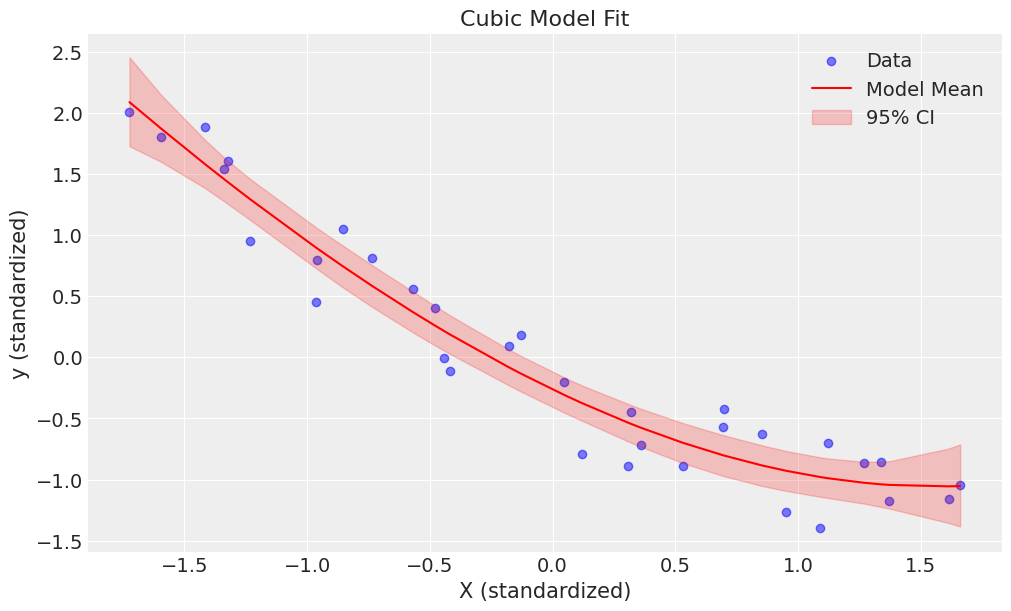


Model Comparison using WAIC (BB-pseudo-BMA):

WAIC Comparison Results:
         rank  elpd_waic    p_waic  elpd_diff    weight        se       dse  \
model_p     0   9.073636  2.631338   0.000000  0.700544  4.685052  0.000000   
model_c     1  10.855176  3.287415   1.781539  0.297963  4.614512  0.708920   
model_l     2  28.580021  2.375711  19.506384  0.001493  5.328922  5.362312   

         warning     scale  
model_p    False  deviance  
model_c    False  deviance  
model_l    False  deviance  


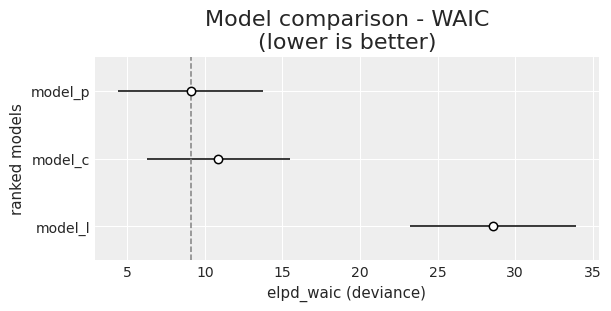


Model Comparison using LOO (BB-pseudo-BMA):

LOO Comparison Results:
         rank   elpd_loo     p_loo  elpd_diff    weight        se       dse  \
model_p     0   9.141779  2.665409   0.000000  0.708450  4.497421  0.000000   
model_c     1  10.986221  3.352937   1.844442  0.290296  4.441568  0.720497   
model_l     2  28.627696  2.399549  19.485918  0.001254  5.367828  5.369914   

         warning     scale  
model_p    False  deviance  
model_c    False  deviance  
model_l    False  deviance  


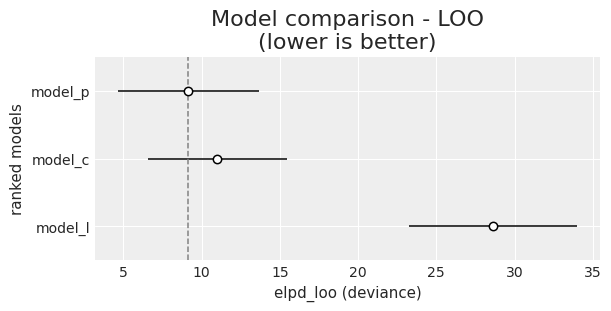

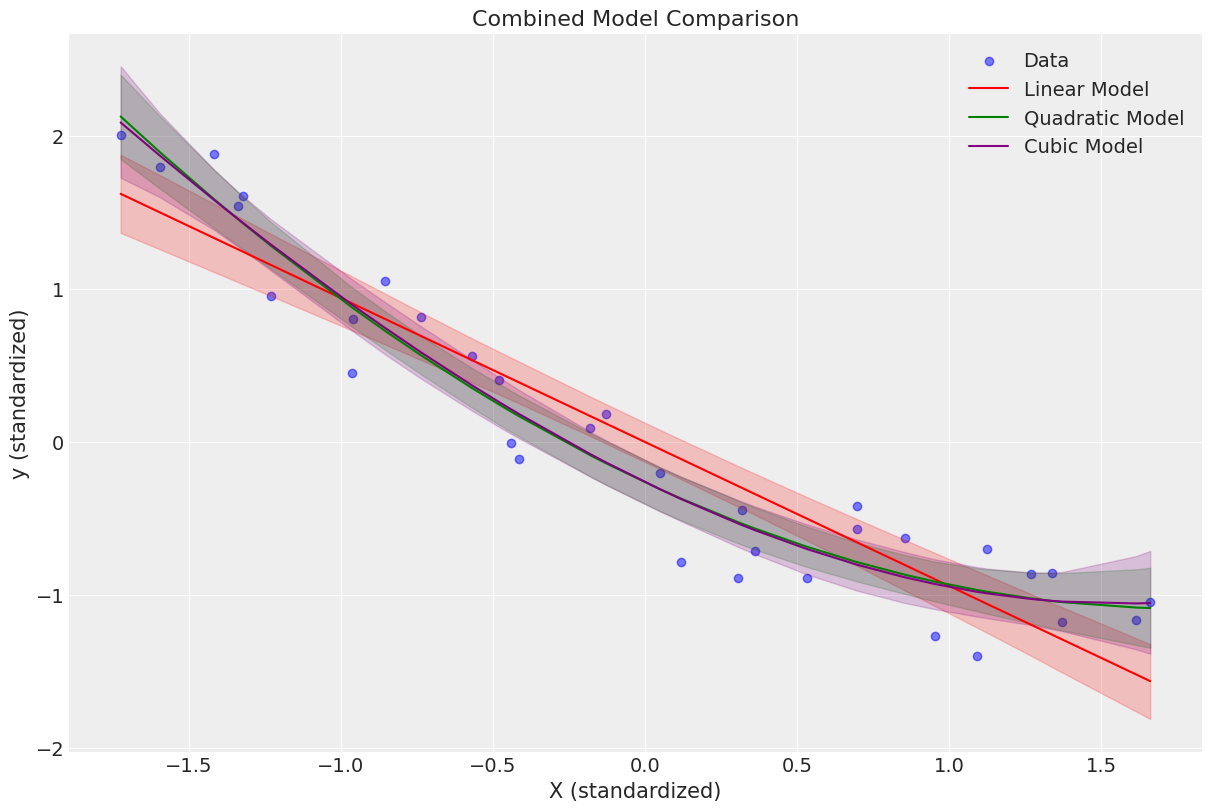

In [20]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats

# Load and prepare data
print("Loading and preparing data...")
data = np.loadtxt('date.csv')
X = data[:, 0]
y = data[:, 1]

# Standardize the data
X_std = (X - X.mean()) / X.std()
y_std = (y - y.mean()) / y.std()

# Function to create polynomial features
def create_polynomial_features(X, order):
    return np.column_stack([X**i for i in range(1, order + 1)])

# Function to plot individual model
def plot_single_model(X, y, trace, order, title):
    plt.figure(figsize=(10, 6))
    
    # Sort X for smooth lines
    X_sort_idx = np.argsort(X)
    X_sorted = X[X_sort_idx]
    
    # Plot data points
    plt.scatter(X, y, color='blue', alpha=0.5, label='Data')
    
    # Get posterior samples
    alpha_samples = trace.posterior['alpha'].values.flatten()
    beta_samples = trace.posterior['beta'].values.reshape(-1, order)
    
    # Calculate predictions
    X_poly = create_polynomial_features(X_sorted, order)
    y_pred = alpha_samples[:, None] + np.dot(beta_samples, X_poly.T)
    
    # Calculate mean and credible intervals
    y_mean = y_pred.mean(axis=0)
    y_lower = np.percentile(y_pred, 2.5, axis=0)
    y_upper = np.percentile(y_pred, 97.5, axis=0)
    
    # Plot
    plt.plot(X_sorted, y_mean, color='red', label='Model Mean')
    plt.fill_between(X_sorted, y_lower, y_upper, color='red', alpha=0.2, label='95% CI')
    
    plt.xlabel('X (standardized)')
    plt.ylabel('y (standardized)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create and sample from model
def create_model(X, y, order, name):
    print(f"\nCreating {name} model (order={order})...")
    with pm.Model() as model:
        # Priors
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        betas = pm.Normal('beta', mu=0, sigma=10, shape=order)
        sigma = pm.HalfNormal('sigma', sigma=10)

        # Create polynomial features
        X_poly = create_polynomial_features(X, order)
        
        # Linear predictor
        mu = alpha + pm.math.dot(betas, X_poly.T)
        
        # Likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
        
        # Sample with log likelihood computation
        print(f"Sampling from {name} model...")
        with model:
            idata = pm.sample(2000, 
                            return_inferencedata=True, 
                            compute_convergence_checks=False,
                            idata_kwargs={"log_likelihood": True})
            
        # Plot individual model
        plot_single_model(X_std, y_std, idata, order, f'{name} Model Fit')
        
        return idata, model

# Create and sample from models sequentially
models = {
    'model_l': (1, 'Linear'),
    'model_p': (2, 'Quadratic'),
    'model_c': (3, 'Cubic')
}

results = {}
model_objects = {}
for model_name, (order, label) in models.items():
    trace, model = create_model(X_std, y_std, order, label)
    results[model_name] = trace
    model_objects[model_name] = model

# Compare models using WAIC
print("\nModel Comparison using WAIC (BB-pseudo-BMA):")
comparison_waic = az.compare(
    {
        'model_l': results['model_l'], 
        'model_p': results['model_p'],
        'model_c': results['model_c']
    },
    method='BB-pseudo-BMA',
    ic='waic',
    scale='deviance'
)

print("\nWAIC Comparison Results:")
print(comparison_waic)

# Plot WAIC comparison
az.plot_compare(comparison_waic)
plt.title("Model comparison - WAIC\n(lower is better)")
plt.show()

# Compare models using LOO
print("\nModel Comparison using LOO (BB-pseudo-BMA):")
comparison_loo = az.compare(
    {
        'model_l': results['model_l'], 
        'model_p': results['model_p'],
        'model_c': results['model_c']
    },
    method='BB-pseudo-BMA',
    ic='loo',
    scale='deviance'
)

print("\nLOO Comparison Results:")
print(comparison_loo)

# Plot LOO comparison
az.plot_compare(comparison_loo)
plt.title("Model comparison - LOO\n(lower is better)")
plt.show()

# Combined plot of all models
plt.figure(figsize=(12, 8))

# Sort X for smooth lines
X_sort_idx = np.argsort(X_std)
X_sorted = X_std[X_sort_idx]

# Plot data points
plt.scatter(X_std, y_std, color='blue', alpha=0.5, label='Data')

# Plot predictions for each model
colors = ['red', 'green', 'purple']
for (model_name, trace), color in zip(results.items(), colors):
    order = models[model_name][0]
    
    # Get posterior samples
    alpha_samples = trace.posterior['alpha'].values.flatten()
    beta_samples = trace.posterior['beta'].values.reshape(-1, order)
    
    # Calculate predictions
    X_poly = create_polynomial_features(X_sorted, order)
    y_pred = alpha_samples[:, None] + np.dot(beta_samples, X_poly.T)
    
    # Calculate mean and credible intervals
    y_mean = y_pred.mean(axis=0)
    y_lower = np.percentile(y_pred, 2.5, axis=0)
    y_upper = np.percentile(y_pred, 97.5, axis=0)
    
    # Plot
    plt.plot(X_sorted, y_mean, color=color, label=f'{models[model_name][1]} Model')
    plt.fill_between(X_sorted, y_lower, y_upper, color=color, alpha=0.2)

plt.xlabel('X (standardized)')
plt.ylabel('y (standardized)')
plt.title('Combined Model Comparison')
plt.legend()
plt.grid(True)
plt.show()